## General Setup

In [1]:
%matplotlib inline
import sqlite3
import pprint
import pandas as pd
#import geopandas as gpd
pd.set_option('display.width', 600)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.max_rows', 100)
from IPython.display import Image
import config
from pygbif import occurrences
import matplotlib.pyplot as plt

gap_id = 'bybcux'
species_id = 'bybcux0'
inDir = '/users/nmtarr/documents/ranges/inputs/'
outDir = '/users/nmtarr/documents/ranges/outputs/'
summary_name = 'cuckoo2' # an short, memorable name to use for file names etc.
years = '2000-2020'
eval_id = 'eval_gbif1'
filter_id = 'f002'
request_id = 'r002'

In [2]:
connjup = sqlite3.connect('/users/nmtarr/documents/ranges/inputs/rng_eval_params.sqlite')
cursorjup = connjup.cursor()

## Species Concept

In [3]:
vals = cursorjup.execute("SELECT * FROM species_concepts;").fetchall()[0]
cols = [x[1] for x in cursorjup.execute("PRAGMA table_info('species_concepts')").fetchall()]
pprint.pprint(dict(zip(cols, vals)))

{'bcb_id': None,
 'breeding_months': '4,5,6,7,8',
 'common_name': 'yellow-billed cuckoo',
 'detection_distance_meters': 200,
 'end_year': None,
 'error_tolerance': 40,
 'fws_id': None,
 'gap_id': 'bybcux',
 'gbif_id': '2496287',
 'geometry': None,
 'itis_tsn': '177831',
 'migratory': '1',
 'notes': 'Manually entered for use in development. ',
 'pad': 2,
 'scientific_name': 'Coccyzus americanus',
 'species_id': 'bybcux0',
 'start_year': None,
 'wintering_months': '11,12,1,2'}


## Retrieve and Filter Occurrence Data

In [4]:
df1 = pd.read_sql_query(sql="SELECT * FROM gbif_requests WHERE request_id = '{0}'".format(request_id), con=connjup)
print("REQUEST FILTER SET")
print(df1.loc[0])

REQUEST FILTER SET
request_id                                                            r002
source                                                                GBIF
lat_range                                                            27,41
lon_range                                                          -91,-75
years_range                                                      2000,2020
months_range                                                          1,12
geoissue                                                              True
coordinate_issue                                                      True
continent                                                    north_america
creator                                                            N. Tarr
notes               Used in development.  Meant to let in lots of records.
Name: 0, dtype: object


In [5]:
df2 = pd.read_sql_query(sql="SELECT * FROM gbif_filters WHERE filter_id = '{0}'".format(filter_id), con=connjup)
print("POST REQUEST FILTER SET")
print(df2.loc[0])

POST REQUEST FILTER SET
filter_id                                                                       f002
source                                                                          GBIF
has_coordinate_uncertainty                                                         0
creator                                                                      N. Tarr
notes                         Used for development.  Should return a lot of records.
Name: 0, dtype: object


In [8]:
# Run a script that retrieves and filters
%run 'retrieve_occurrences.py'

downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__89%2Fbb%2F19%2F89bb19045ef553fdf3a05056b81618649e77e351 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.zip
downloading https://www.sciencebase.gov/catalog/file/get/59f5e201e4b063d5d307dc0f?f=__disk__db%2Fb5%2F9a%2Fdbb59a7ae14e77d87bd9a6f527f91dd55e577628 to /Users/nmtarr/Documents/RANGES/Inputs/bYBCUx_CONUS_Range_2001v1.xml


IntegrityError: UNIQUE constraint failed: spatial_ref_sys.srid

<Figure size 432x288 with 0 Axes>

OSError: cannot locate /users/nmtarr/documents/ranges/outputs/cuckoo2_circles.shp

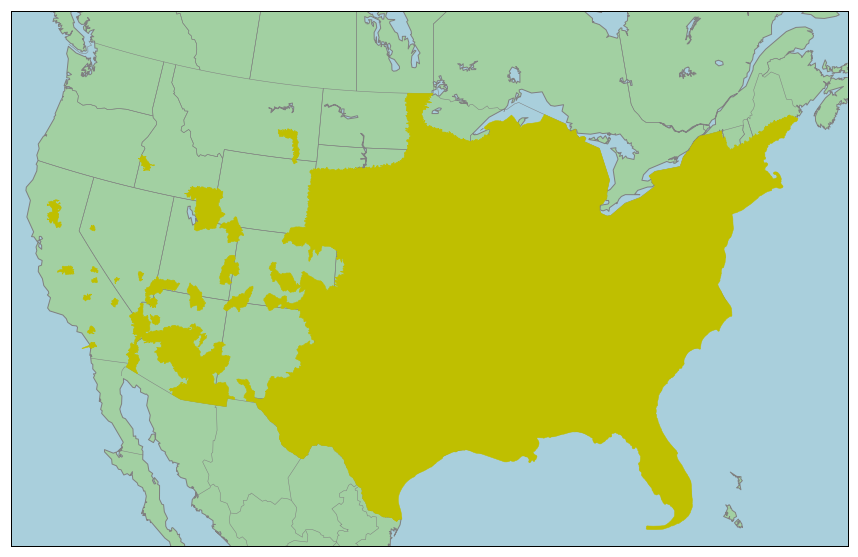

In [7]:
gap_range2 = "{0}{1}_range_4326".format(inDir, gap_id)

shp1 = {'file': gap_range2, 'column': None, 'alias': 'GAP range map',
        'drawbounds': False, 'linewidth': .5, 'linecolor': 'y',
        'fillcolor': 'y', 'marker':'s'}

shp2 = {'file': '{0}{1}_circles'.format(outDir, summary_name), 'column': None,
        'alias': 'Occurrence records', 'drawbounds': True, 'linewidth': .75, 'linecolor': 'k',
        'fillcolor': None, 'marker':'o'}

# Display occurrence polygons
title="Yellow-billed Cuckoo ({0})".format(years)
config.MapShapefilePolygons(map_these=[shp1, shp2], title=title)

### Where were records retrieved from for the evaluation?

In [ ]:
tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

filter_sets = cursorjup.execute("SELECT filter_sets FROM evaluations WHERE evaluation_id = 'eval_gbif1'").fetchone()[0]
filter_sets = filter_sets.split(",")

sources = []
for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns = [x[0] for x in columns]
        for col in columns:
            try:
                a = cursorjup.execute("SELECT source FROM {1} WHERE {2} = '{0}'".format(s, tab, col)).fetchone()[0]
                sources.append(a)
            except:
                pass
print(list(set(sources))[0])

### What was the filtering criteria for the data used in the evaluation?

In [ ]:
filter_sets = cursorjup.execute("SELECT filter_sets FROM evaluations WHERE evaluation_id = 'eval_gbif1'").fetchone()[0]
filter_sets = filter_sets.split(",")

tables = cursorjup.execute("SELECT table_name FROM table_descriptions").fetchall()
tables = [x[0] for x in tables]

for s in filter_sets:
    s = s.strip()
    for tab in tables:
        columns = cursorjup.execute("SELECT column_name FROM column_descriptions WHERE table_name = '{0}'".format(tab)).fetchall()
        columns=[x[0] for x in columns]   
        for col in columns:
            try:
                df1 = pd.read_sql_query(sql="SELECT * FROM {0} WHERE {1} = '{2}'".format(tab, col, s), con=connjup)
                print(df1.iloc[0]) 
                print('\n')
            except:
                pass

### How many records made it through the filters?

In [ ]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
record_count = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences WHERE species_id = '{0}'".format(species_id)).fetchone()
print(str(record_count[0]) + " records made it through the filters")

### What years were represented in the data?

In [ ]:
occ_years = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%Y', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_years, bins=20)
plt.ylabel("number of occurrences")
plt.xlabel("year")
plt.title("Occurrences per Year")

### What months were represented in the data?

In [ ]:
occ_months = [int(x[0]) for x in curs_occ.execute("SELECT strftime('%m', occurrenceDate) FROM occurrences").fetchall()]
plt.hist(occ_months, bins=range(1, 14), color="g")
plt.ylabel("number of occurrences")
plt.xlabel("month")
plt.xticks(range(1, 13))
plt.title("Occurrences per Month")

### What months were represented in the data?

In [ ]:
occ_cert = [int(x[0]) for x in curs_occ.execute("SELECT coordinateUncertaintyInMeters FROM occurrences").fetchall()]
plt.hist(occ_cert, color="r")
plt.ylabel("number of records")
plt.xlabel("coordinate uncertainty")
plt.title("Coordinate Uncertainty")

### What issues were present in the data?

In [ ]:
conn_occ= sqlite3.connect(outDir + species_id + "_occurrences.sqlite")
curs_occ = conn_occ.cursor()
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
issues = set([])
for id in occ_ids:
    occdict = occurrences.get(key=id)
    issues = issues | set(occdict['issues'])
for x in list(issues):
    print(x)

### What were the bases of the records?

In [ ]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
bases = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    BOR = occdict['basisOfRecord']
    if BOR == "" or BOR == None:
        bases.append("UNKNOWN")
    else:
        bases.append(BOR)
for x in list(set(bases)):
    print(x)

### Who provided the records?

In [ ]:
occ_ids = [x[0] for x in curs_occ.execute("SELECT occ_id FROM occurrences").fetchall()]
by = []
for id in occ_ids:
    occdict = occurrences.get(key=id)
    try:
        who = occdict['institutionID']
        by.append(who)
    except:
        who = occdict['institutionCode']
        by.append(who)
for x in list(set(by)):
    print(x)

### Were there duplicate records?

In [ ]:
dups0 = curs_occ.execute("SELECT COUNT(occ_id) FROM occurrences GROUP BY geom_xy4326, occurrenceDate;").fetchall()
dups1 = [x[0] for x in dups0]
dups2 = [x for x in dups1 if x > 1]
print(str(len(dups2)) + ' records were duplicates based on xy coordinate and date-time')